In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sns.reset_defaults()
sns.set_theme(rc={"figure.dpi": 72, "savefig.dpi": 300,
              "figure.autolayout": True})
sns.set_style("ticks")
sns.set_context("paper")

np.set_printoptions(precision=4)


In [2]:
# Part a

from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.mixture import GaussianMixture

df1 = pd.read_csv("data/P2/D1/Skin-NonSkin.txt",
                  names=["R", "G", "B", "Skin"], delim_whitespace=True, dtype=int)
df1 = df1.drop_duplicates()
df1 = df1.drop_duplicates(subset=["R", "G", "B"], keep=False)
df1["Skin"] = df1["Skin"] == 2
df1["Skin"] = df1["Skin"].astype(int)
X1 = df1[["R", "G", "B"]].values
y1 = df1["Skin"].values

ss1 = StandardScaler()


def RGB2YCrCb(X):
    C = [[.299, .587, .114], [-.168736, -.331364, .5], [.5, -.418688, -.081312]]
    C = np.array(C)
    X = X @ C.T
    X[:, 1:] += 128
    return X


def prep1(X, train=False, **kwargs):
    X_ = RGB2YCrCb(X)
    X_ = X_[:, 1:]
    if train:
        ss1.fit(X_)
    X_ = ss1.transform(X_)
    return X_


X1 = prep1(X1, True)

gmm = GaussianMixture(n_components=4, random_state=2)
y1_pred = gmm.fit_predict(X1)

labels = [0] * gmm.n_components
for c in range(gmm.n_components):
    s = y1_pred == c
    l, cnt = np.unique(y1[s], return_counts=True)
    labels[c] = l[np.argmax(cnt)]


In [3]:
# Part b

import os
from sklearn.metrics import classification_report, confusion_matrix


def eval(mdl, labels=[0, 1], thr=0.5, prep=prep1, part="b", test_dir="data/P2/D2/images/", truth_dir="data/P2/D2/groundtruth/"):
    mname = mdl.__class__.__name__
    labels = np.array(labels)
    files = [f for f in os.listdir(test_dir) if f.endswith(".jpg")]
    y_preds = np.array([])
    y_trues = np.array([])

    fig, axes = plt.subplots(len(files), 2, figsize=(5, 2*len(files)))
    for ax in axes.flatten():
        ax.axis('off')

    for i, f in enumerate(files):
        img_true = plt.imread((truth_dir + f).replace(".jpg", ".png"))
        img_test = plt.imread(test_dir + f)

        X_true = img_true.reshape((img_true.shape[0] * img_true.shape[1], -1))[:, :3]
        X_test = img_test.reshape((img_test.shape[0] * img_test.shape[1], 3))
        X_test = prep(X_test, imshape=img_test.shape)

        y_true = X_true.mean(axis=1) > np.max(X_true) / 2
        y_true = y_true.astype(int)
        y_trues = np.r_[y_trues, y_true]

        y_pred = mdl.predict_proba(X_test)[:, 0]
        y_pred = y_pred < thr

        y_pred = y_pred.astype(int)
        y_pred = labels[y_pred]
        y_preds = np.r_[y_preds, y_pred]

        z = y_pred.reshape(img_test.shape[0], img_test.shape[1])
        mask = np.zeros(img_test.shape, dtype=int)
        mask[z == 1] = [255] * 3

        axes[i, 0].imshow(img_test)
        axes[i, 1].imshow(mask)

    print(f"Results for {mname}:")
    print(classification_report(y_trues, y_preds, labels=[
          1, 0], target_names=["Skin", "Non-skin"]))
    print("Confusion Matrix:")
    print(confusion_matrix(y_trues, y_preds, normalize="all"))

    fig.savefig(f"P2_{part}_{mname}.png")
    plt.show()


Results for GaussianMixture:
              precision    recall  f1-score   support

        Skin       0.32      0.98      0.48    423636
    Non-skin       0.99      0.61      0.76   2289542

    accuracy                           0.67   2713178
   macro avg       0.65      0.79      0.62   2713178
weighted avg       0.89      0.67      0.71   2713178

Confusion Matrix:
[[0.5156 0.3283]
 [0.0039 0.1522]]


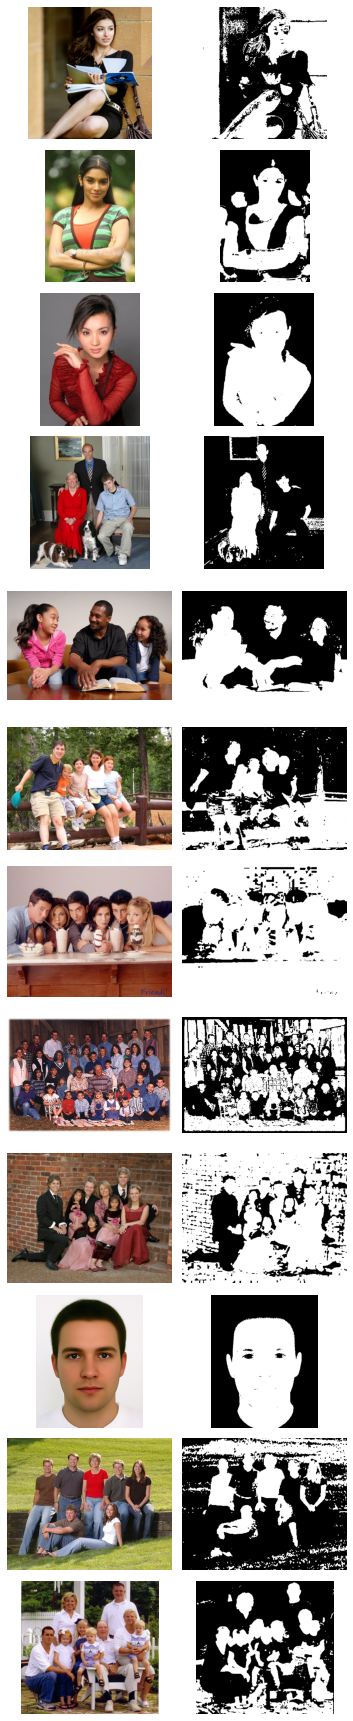

In [4]:
eval(gmm, labels, thr=0.9, part="b")

Results for GaussianNB:
              precision    recall  f1-score   support

        Skin       0.39      0.89      0.54    423636
    Non-skin       0.97      0.74      0.84   2289542

    accuracy                           0.76   2713178
   macro avg       0.68      0.81      0.69   2713178
weighted avg       0.88      0.76      0.79   2713178

Confusion Matrix:
[[0.6244 0.2195]
 [0.0179 0.1382]]


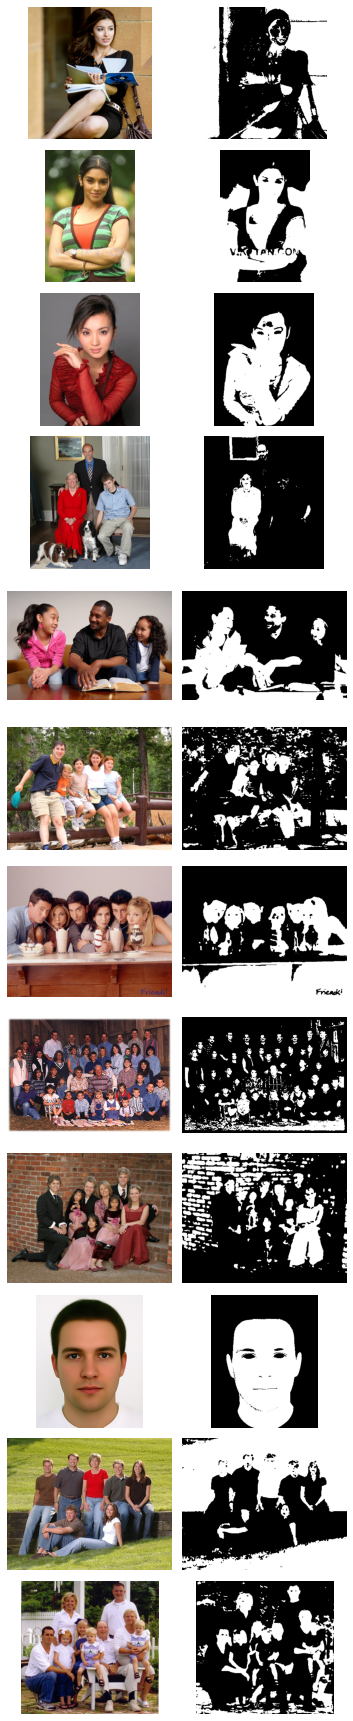

In [5]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB().fit(X1, y1)
eval(gnb, thr=1e-16, part="c")


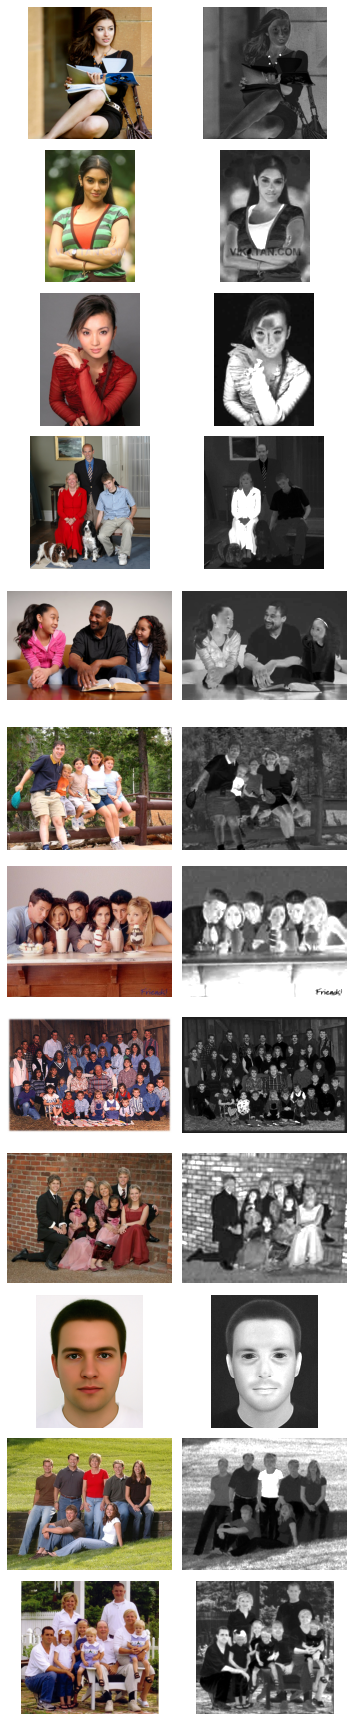

In [6]:
# Part d

def skin_probability(mdl, part="d", test_dir="data/P2/D2/images/"):
    mname = mdl.__class__.__name__
    files = [f for f in os.listdir(test_dir)]

    fig, axes = plt.subplots(len(files), 2, figsize=(5, 2*len(files)))
    for ax in axes.flatten():
        ax.axis('off')

    for i, f in enumerate(files):
        img_test = plt.imread(test_dir + f)

        X_test = img_test.reshape((img_test.shape[0] * img_test.shape[1], 3))
        X_test = prep1(X_test)

        y_pred = mdl.predict_log_proba(X_test)[:, 0]
        y_pred = 1 - minmax_scale(y_pred)
        y_pred *= 1.5

        z = y_pred.reshape(img_test.shape[0], img_test.shape[1])

        axes[i, 0].imshow(img_test)
        axes[i, 1].imshow(z, cmap='gray', vmin=0, vmax=1)

    fig.savefig(f"P2_{part}_{mname}.png")
    plt.show()


skin_probability(gnb)


In [7]:
# Part e

from scipy.ndimage import generic_filter


def generate_dataset(mdl, test_dir="data/P2/pratheepan/images/", truth_dir="data/P2/pratheepan/groundtruth/"):
    mname = mdl.__class__.__name__
    files = [f for f in os.listdir(test_dir) if f.endswith(".jpg")]
    data = np.array([]).reshape((-1, 13))

    for i, f in enumerate(files):
        img_true = plt.imread((truth_dir + f).replace(".jpg", ".png"))
        img_test = plt.imread(test_dir + f)

        X_true = img_true.reshape((img_true.shape[0] * img_true.shape[1], -1))[:, :3]
        X_test = img_test.reshape((img_test.shape[0] * img_test.shape[1], 3))
        X_test_prep = prep1(X_test)

        y_true = X_true.mean(axis=1) > np.max(X_true) / 2
        y_true = y_true.astype(int)

        y_pred = mdl.predict_log_proba(X_test_prep)[:, 0]
        y_pred = 1 - minmax_scale(y_pred)
        z = y_pred.reshape(img_test.shape[0], img_test.shape[1])

        nbr_probs = []

        def func(nbrs):
            nbr_probs.append(nbrs)
            return 0

        generic_filter(z, func, footprint=np.ones((3, 3)), mode="constant")
        nbr_probs = np.array(nbr_probs)
        nbr_probs = np.c_[nbr_probs[:, 4], nbr_probs[:, :4], nbr_probs[:, 5:]]
        data = np.r_[data, np.c_[X_test, nbr_probs, y_true]]

    nbrs = [f"NBRP{i + 1}" for i in range(8)]
    data = pd.DataFrame(data, columns=["R", "G", "B", "P", *nbrs, "Target"])
    data["Target"] = data["Target"].astype(int)
    return data


df2 = generate_dataset(gnb)
df2


,R,G,B,P,NBRP1,NBRP2,NBRP3,NBRP4,NBRP5,NBRP6,NBRP7,NBRP8,Target
0,215.0,203.0,177.0,0.199259,0.000000,0.000000,0.000000,0.000000,0.205903,0.000000,0.222036,0.234278,0
1,199.0,188.0,160.0,0.205903,0.000000,0.000000,0.000000,0.199259,0.205908,0.222036,0.234278,0.234283,0
2,204.0,193.0,165.0,0.205908,0.000000,0.000000,0.000000,0.205903,0.205907,0.234278,0.234283,0.239435,0
3,203.0,192.0,164.0,0.205907,0.000000,0.000000,0.000000,0.205908,0.205909,0.234283,0.239435,0.226891,0
4,205.0,194.0,166.0,0.205909,0.000000,0.000000,0.000000,0.205907,0.205913,0.239435,0.226891,0.226894,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14126842,164.0,165.0,167.0,0.098849,0.095542,0.100970,0.106090,0.094413,0.102363,0.000000,0.000000,0.000000,0
14126843,162.0,160.0,163.0,0.102363,0.100970,0.106090,0.108355,0.098849,0.106086,0.000000,0.000000,0.000000,0
14126844,164.0,159.0,163.0,0.106086,0.106090,0.108355,0.105994,0.102363,0.105993,0.000000,0.000000,0.000000,0
14126845,166.0,156.0,164.0,0.105993,0.108355,0.105994,0.105991,0.106086,0.105991,0.000000,0.000000,0.000000,0


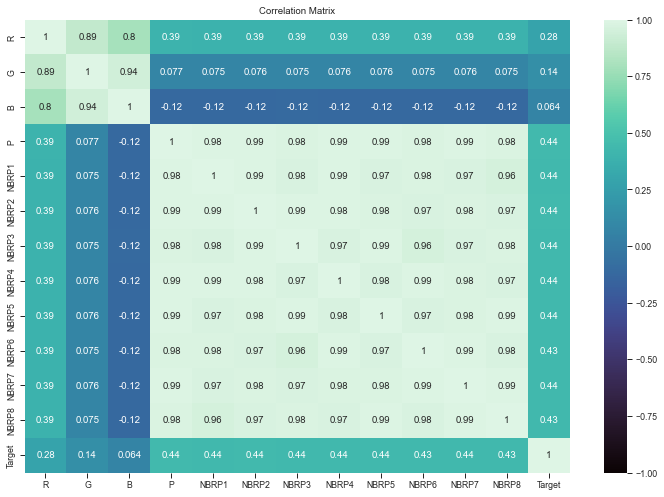

In [8]:
# Part f

fig, ax = plt.subplots(figsize=(10, 7))
ax.set(title="Correlation Matrix")
sns.heatmap(df2.corr(), annot=True, ax=ax, vmin=-1, vmax=1, cmap="mako")
fig.savefig("P2_f.png")
plt.show()


In [9]:
# Part g

from sklearn.linear_model import LogisticRegression

X2 = df2.drop(columns=["Target"]).values
y2 = df2["Target"].values

ss2 = StandardScaler()


def prep2(X, train=False, mdl=gnb, imshape=None):
    if train:
        ss2.fit(X)
    else:
        X_prep = prep1(X)
        y_pred = mdl.predict_log_proba(X_prep)[:, 0]
        y_pred = 1 - minmax_scale(y_pred)
        z = y_pred.reshape(imshape[0], imshape[1])

        nbr_probs = []

        def func(nbrs):
            nbr_probs.append(nbrs)
            return 0

        generic_filter(z, func, footprint=np.ones((3, 3)), mode="constant")
        nbr_probs = np.array(nbr_probs)
        nbr_probs = np.c_[nbr_probs[:, 4], nbr_probs[:, :4], nbr_probs[:, 5:]]
        X = np.c_[X, nbr_probs]
    X = ss2.transform(X)
    return X


X2 = prep2(X2, train=True)

lr = LogisticRegression().fit(X2, y2)


Results for LogisticRegression:
              precision    recall  f1-score   support

        Skin       0.42      0.78      0.55    423636
    Non-skin       0.95      0.80      0.87   2289542

    accuracy                           0.80   2713178
   macro avg       0.69      0.79      0.71   2713178
weighted avg       0.87      0.80      0.82   2713178

Confusion Matrix:
[[0.6757 0.1682]
 [0.034  0.1221]]


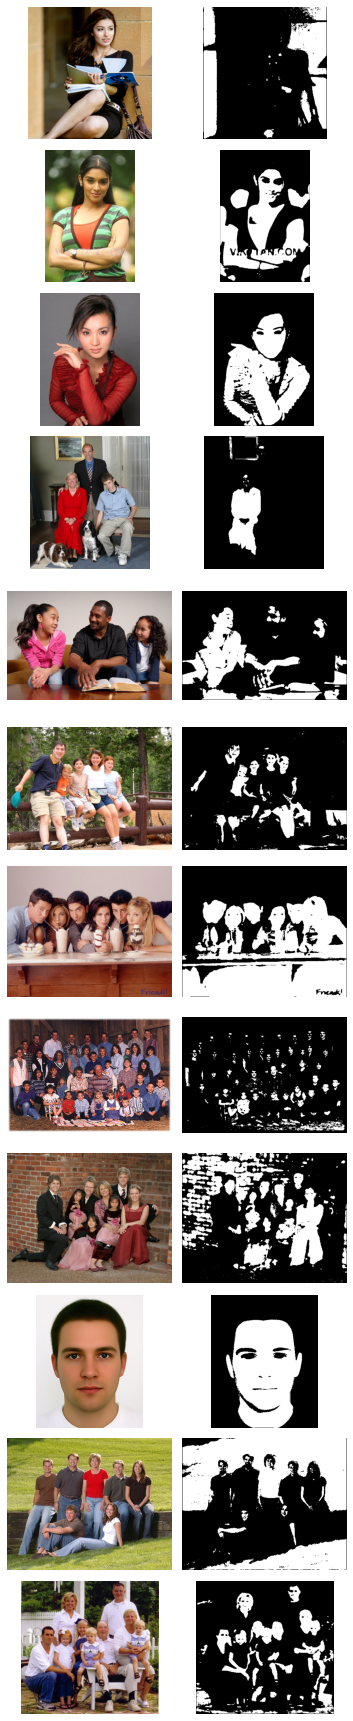

In [10]:
eval(lr, thr=0.75, prep=prep2, part="g")